[*********************100%***********************]  1 of 1 completed


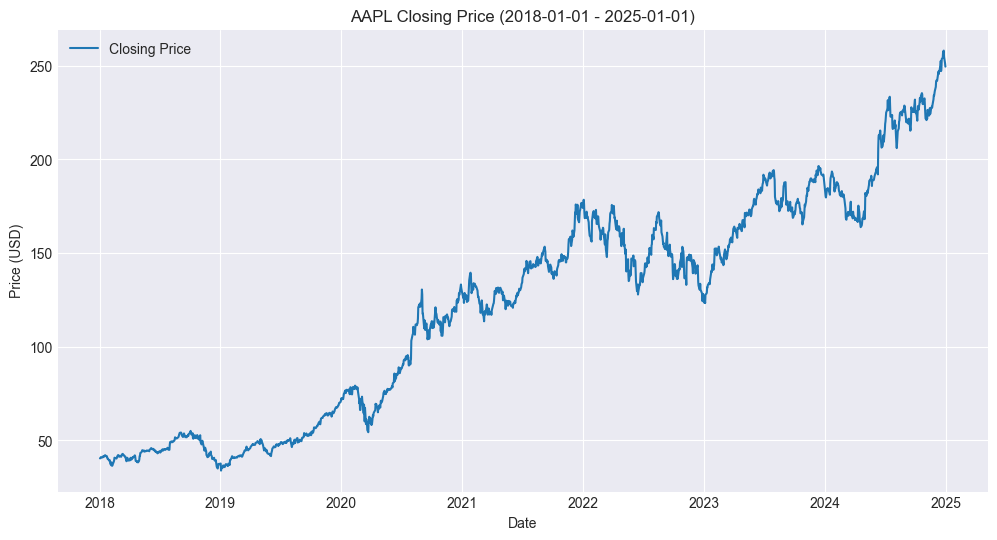

In [9]:
# Part 1: Data Collection and Initial Exploration

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

# Download historical stock data
ticker = "AAPL"
start_date = "2018-01-01"
end_date = "2025-01-01"

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# Save dataset for reuse
data.to_csv(f"{ticker}_historical.csv")

# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(data["Close"], label="Closing Price")
plt.title(f"{ticker} Closing Price ({start_date} - {end_date})")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()



ADF Statistic: 0.0396
p-value: 0.9617
Series is non-stationary, differencing will be applied


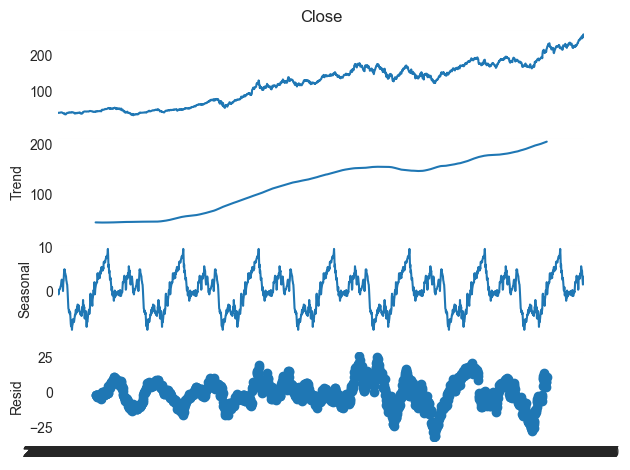

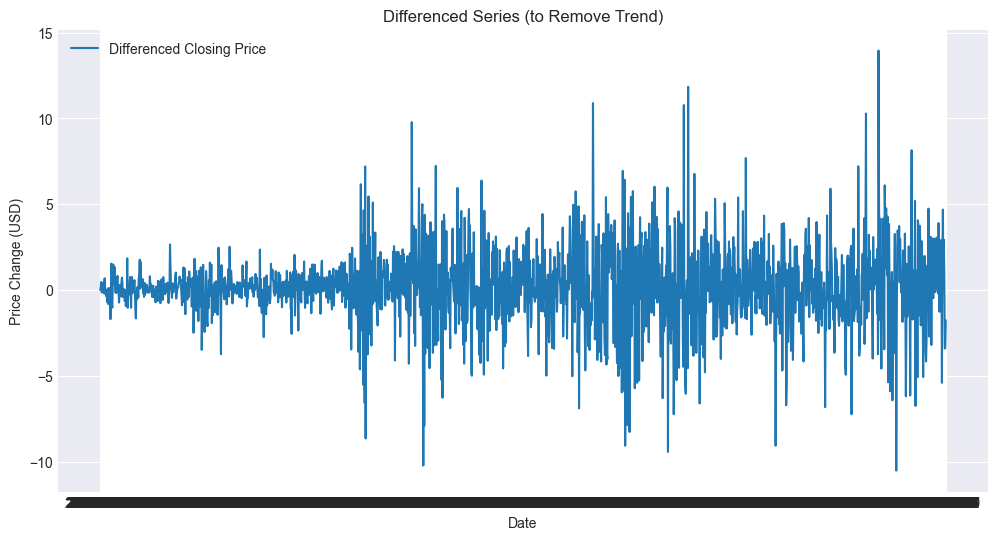

In [10]:
# Part 2: Data Preparation and Stationarity Check

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dataset
file_path = r"D:\UNI STUFF\Data science\Project 3 - Stock Price Prediction\notebooks\AAPL_historical.csv"
data = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Ensure data is numeric and clean
data = data.apply(pd.to_numeric, errors="coerce").dropna()
close = data["Close"]

# ADF Test for stationarity
adf_result = adfuller(close)
print(f"\nADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] <= 0.05:
    print("Series is stationary")
else:
    print("Series is non-stationary, differencing will be applied")

# Seasonal decomposition
decomposition = seasonal_decompose(close, model="additive", period=252)
decomposition.plot()
plt.show()

# Differencing to remove trend
diff_close = close.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(diff_close, label="Differenced Closing Price")
plt.title("Differenced Series (to Remove Trend)")
plt.xlabel("Date")
plt.ylabel("Price Change (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Save differenced data
diff_close.to_csv(r"D:\UNI STUFF\Data science\Project 3 - Stock Price Prediction\notebooks\AAPL_diff.csv")


Training points: 1408
Testing points: 353

Aligned test length: 353
Aligned forecast length: 353

ARIMA(5, 1, 2) evaluation on test window
MAE: 24.8838
MSE: 1120.6727
RMSE: 33.4764


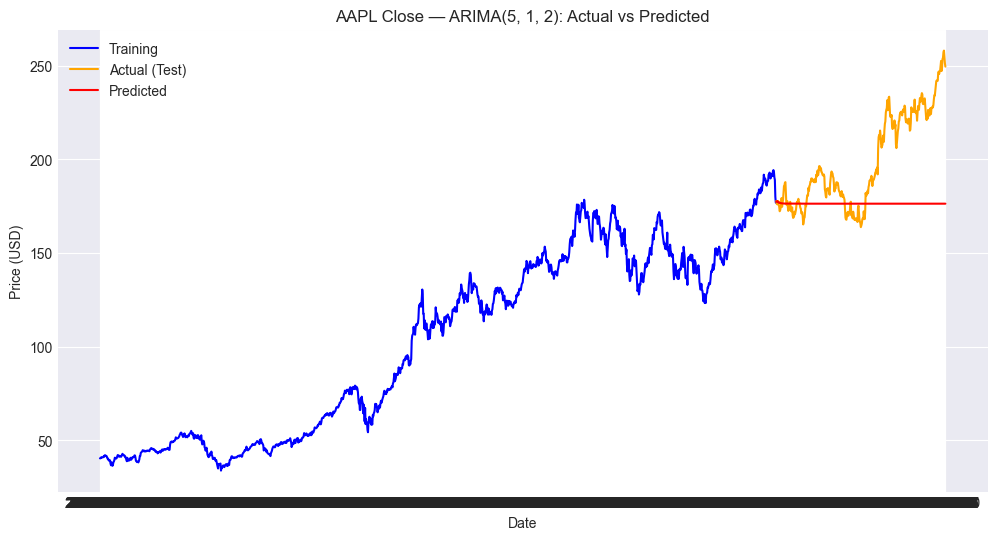

In [ ]:
# Part 3: ARIMA Modeling (Working Version)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
csv_path = r"D:\UNI STUFF\Data science\Project 3 - Stock Price Prediction\notebooks\AAPL_historical.csv"
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
df = df.sort_index()
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna(subset=["Close"])

close = df["Close"]

# Split into training and testing sets
split_idx = int(len(close) * 0.8)
train, test = close.iloc[:split_idx], close.iloc[split_idx:]

print(f"Training points: {len(train)}")
print(f"Testing points: {len(test)}")

# Fit ARIMA model
order = (5, 1, 2)
model = ARIMA(train, order=order)
fit = model.fit()

# Forecast for test period (use get_forecast for stability)
forecast_obj = fit.get_forecast(steps=len(test))
forecast = forecast_obj.predicted_mean

# Align forecast index with test
forecast.index = test.index

# Drop NaNs and realign lengths safely
test = test.dropna()
forecast = forecast.dropna()
n = min(len(test), len(forecast))
test = test.iloc[:n]
forecast = forecast.iloc[:n]

# Check lengths before evaluation
print(f"\nAligned test length: {len(test)}")
print(f"Aligned forecast length: {len(forecast)}")

if n > 0:
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = sqrt(mse)

    print(f"\nARIMA{order} evaluation on test window")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Training", color="blue")
    plt.plot(test, label="Actual (Test)", color="orange")
    plt.plot(forecast, label="Predicted", color="red")
    plt.title(f"AAPL Close — ARIMA{order}: Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\n No valid data points for evaluation. Check forecast output.")


Training points: 1408
Testing points: 353

Best ARIMA order by AIC: (2, 2, 3) (AIC=6165.47)

Aligned test length: 353
Aligned forecast length: 353

Validation metrics:
MAE: 14.6883
MSE: 321.1235
RMSE: 17.9199


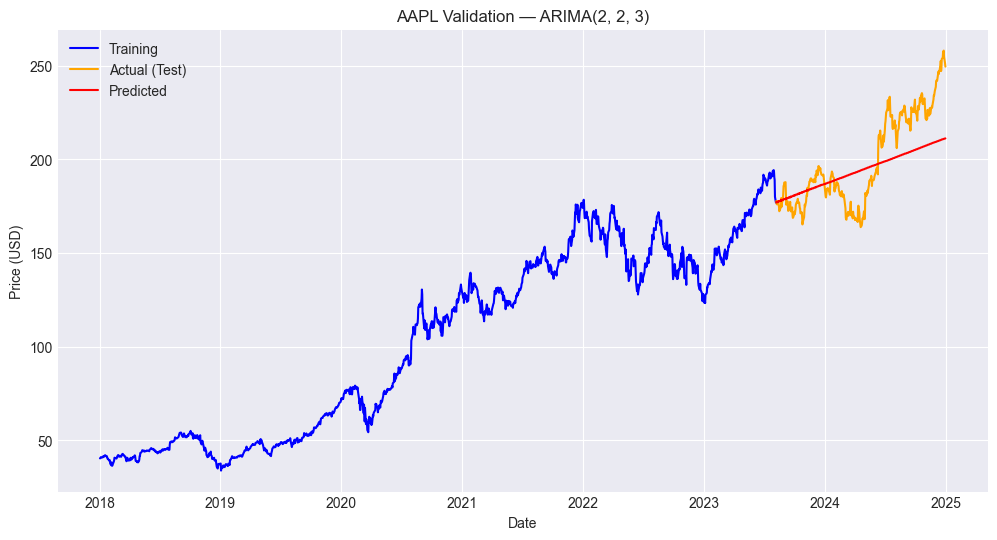

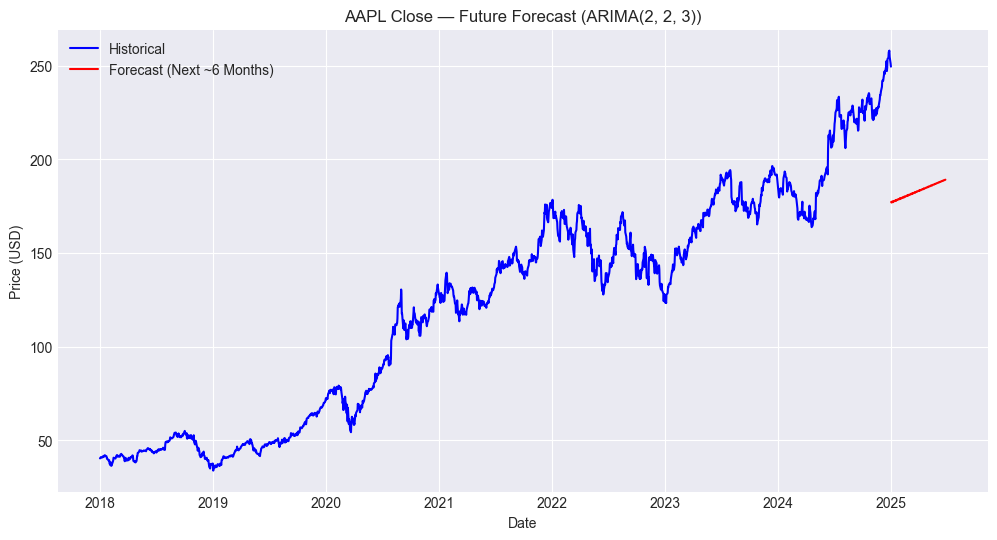

In [18]:
# Part 4: ARIMA Grid Search and 6-Month Forecast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Load dataset
csv_path = r"D:\UNI STUFF\Data science\Project 3 - Stock Price Prediction\notebooks\AAPL_historical.csv"
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
df = df.sort_index()
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna(subset=["Close"])
close = df["Close"]

# Make sure the index is datetime
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.dropna(subset=["Close"])
close = df["Close"]

# Split into train and test
split_idx = int(len(close) * 0.8)
train, test = close.iloc[:split_idx], close.iloc[split_idx:]

print(f"Training points: {len(train)}")
print(f"Testing points: {len(test)}")

# Grid search for best (p, d, q)
best_aic = np.inf
best_order = None
for p in range(6):
    for d in range(3):
        for q in range(6):
            try:
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"\nBest ARIMA order by AIC: {best_order} (AIC={best_aic:.2f})")

# Fit final model with best parameters
model = ARIMA(train, order=best_order)
fit = model.fit()

# Forecast for test data
forecast_obj = fit.get_forecast(steps=len(test))
forecast = forecast_obj.predicted_mean
forecast.index = test.index

# Drop NaNs and align data
test = test.dropna()
forecast = forecast.dropna()
n = min(len(test), len(forecast))
test = test.iloc[:n]
forecast = forecast.iloc[:n]

print(f"\nAligned test length: {len(test)}")
print(f"Aligned forecast length: {len(forecast)}")

# Evaluate model performance
if n > 0:
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = sqrt(mse)

    print(f"\nValidation metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Plot training, actual test, and predicted
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train.values, label="Training", color="blue")
    plt.plot(test.index, test.values, label="Actual (Test)", color="orange")
    plt.plot(forecast.index, forecast.values, label="Predicted", color="red")
    plt.title(f"AAPL Validation — ARIMA{best_order}")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Forecast next 6 months (126 business days)
    future_steps = 126
    future_forecast_obj = fit.get_forecast(steps=future_steps)
    future_forecast = future_forecast_obj.predicted_mean

    # Force proper datetime index
    df.index = pd.to_datetime(df.index, errors='coerce')
    last_date = pd.to_datetime(df.index[-1])
    future_index = pd.bdate_range(start=last_date + timedelta(days=1),
                                  periods=future_steps)

    # Ensure both arrays are same length and dtype
    future_forecast = np.array(future_forecast[:len(future_index)])

    # Plot historical + future forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, close.values, label="Historical", color="blue")
    plt.plot(future_index, future_forecast, label="Forecast (Next ~6 Months)", color="red")
    plt.title(f"AAPL Close — Future Forecast (ARIMA{best_order})")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\n No valid data points for evaluation. Check forecast output.")


LSTM Evaluation:
MAE: 6.2073
MSE: 59.4736
RMSE: 7.7119


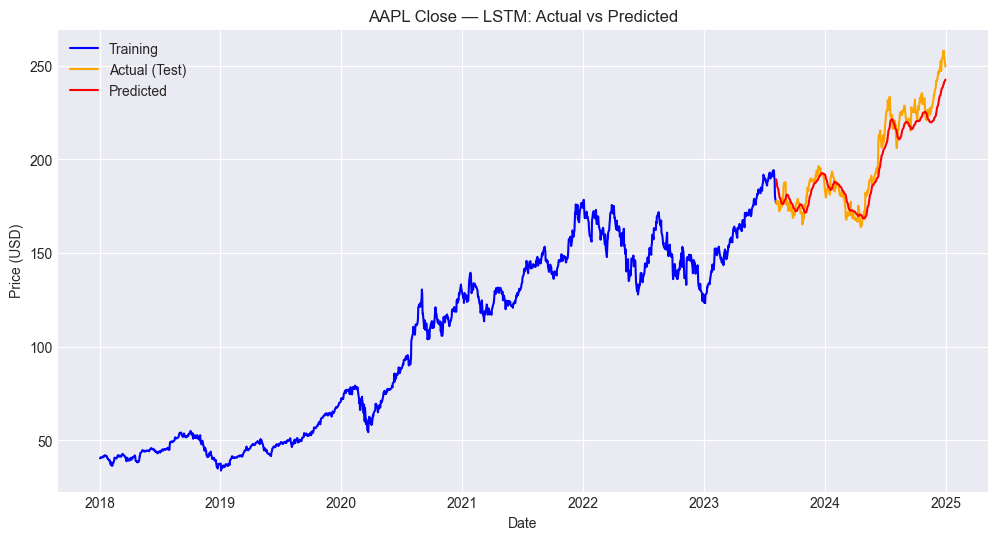

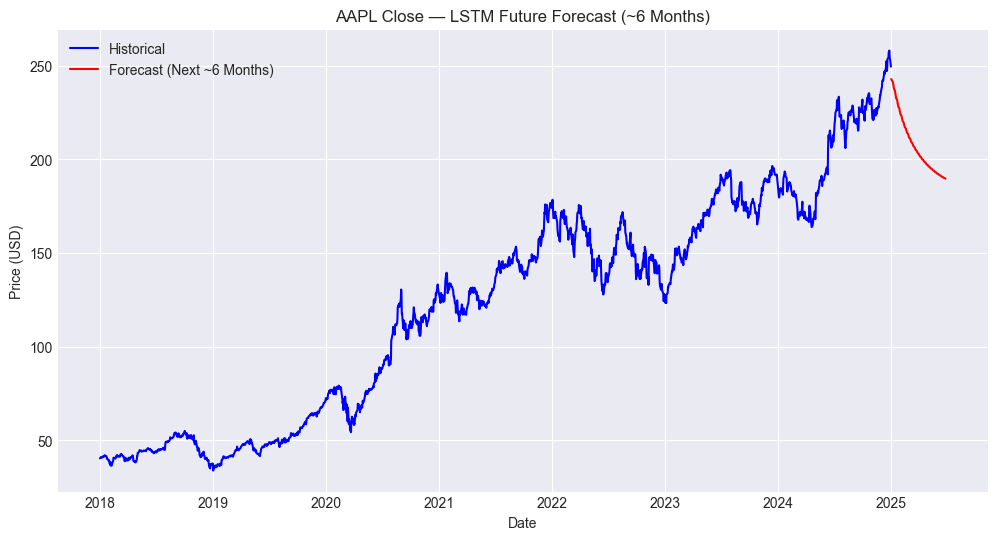

In [20]:
# Part 5: LSTM – test evaluation + 6-month forecast


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler 


# Reuse the same 'close' Series loaded earlier
# If not, uncomment the following:
# close = df["Close"]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all = scaler.fit_transform(close.values.reshape(-1, 1))

# Function to create time-windowed sequences
def make_sequences(arr, window=60):
    X, y = [], []
    for i in range(window, len(arr)):
        X.append(arr[i - window:i, 0])
        y.append(arr[i, 0])
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

window = 60
X_all, y_all = make_sequences(scaled_all, window=window)
y_dates = close.index[window:]

split_idx_seq = int(len(close) * 0.8) - window
X_train, y_train = X_all[:split_idx_seq], y_all[:split_idx_seq]
X_test, y_test = X_all[split_idx_seq:], y_all[split_idx_seq:]
test_dates = y_dates[split_idx_seq:]

# LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=60, batch_size=32, callbacks=[es], verbose=0)

# Predict test
y_pred_scaled = model.predict(X_test, verbose=0).ravel()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrics
mae = mean_absolute_error(y_test_prices, y_pred)
mse = mean_squared_error(y_test_prices, y_pred)
rmse = sqrt(mse)
print(f"LSTM Evaluation:\nMAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training", color="blue")
plt.plot(test, label="Actual (Test)", color="orange")
plt.plot(pd.Series(y_pred, index=test_dates), label="Predicted", color="red")
plt.title("AAPL Close — LSTM: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Forecast ~6 months (126 business days)
future_steps = 126
last_seq = scaled_all[-window:].reshape(1, window, 1)
future_scaled = []

for _ in range(future_steps):
    next_scaled = model.predict(last_seq, verbose=0)[0, 0]
    future_scaled.append(next_scaled)
    last_seq = np.concatenate([last_seq[:, 1:, :], np.array(next_scaled).reshape(1, 1, 1)], axis=1)

future_prices = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).ravel()
future_index = pd.bdate_range(close.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq="B")

# Plot historical + forecast
plt.figure(figsize=(12, 6))
plt.plot(close, label="Historical", color="blue")
plt.plot(pd.Series(future_prices, index=future_index), label="Forecast (Next ~6 Months)", color="red")
plt.title("AAPL Close — LSTM Future Forecast (~6 Months)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Performance Comparison:
ARIMA  → MAE: 14.6883, RMSE: 17.9199
LSTM   → MAE: 6.2073, RMSE: 7.7119


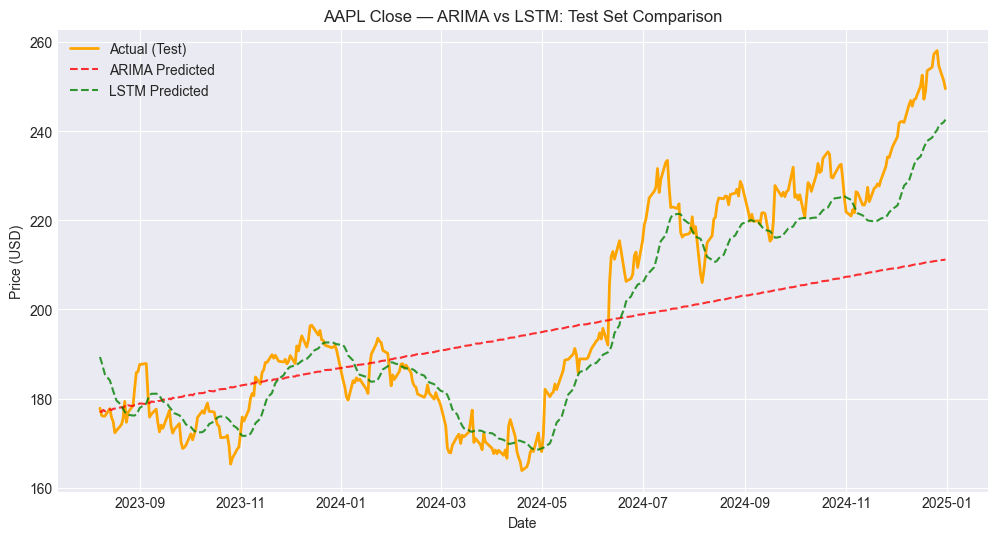

In [22]:
# Part 6: ARIMA vs LSTM Comparison on Test Window

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np

# Recreate the LSTM predictions if not already stored
# (assuming 'model' is your trained LSTM and test_scaled, X_test, y_test exist)

try:
    lstm_predicted
except NameError:
    # Generate predictions from LSTM
    lstm_predicted = model.predict(X_test)
    lstm_predicted = scaler.inverse_transform(lstm_predicted).flatten()
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    test_index = close.index[-len(y_test_unscaled):]
else:
    # If variable already exists, reuse it
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    test_index = close.index[-len(y_test_unscaled):]

# Align ARIMA forecast to the same test window
n = min(len(test_index), len(forecast))
aligned_test = test[-n:]
aligned_arima = forecast[-n:]
aligned_lstm = lstm_predicted[-n:]

# Calculate metrics
arima_mae = mean_absolute_error(aligned_test, aligned_arima)
arima_rmse = sqrt(mean_squared_error(aligned_test, aligned_arima))

lstm_mae = mean_absolute_error(aligned_test, aligned_lstm)
lstm_rmse = sqrt(mean_squared_error(aligned_test, aligned_lstm))

print("Performance Comparison:")
print(f"ARIMA  → MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}")
print(f"LSTM   → MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

# Plot both models against actual test data
plt.figure(figsize=(12,6))
plt.plot(aligned_test.index, aligned_test, label="Actual (Test)", color="orange", linewidth=2)
plt.plot(aligned_arima.index, aligned_arima, label="ARIMA Predicted", color="red", linestyle="--", alpha=0.8)
plt.plot(aligned_test.index, aligned_lstm, label="LSTM Predicted", color="green", linestyle="--", alpha=0.8)

plt.title("AAPL Close — ARIMA vs LSTM: Test Set Comparison")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


Part 7: Final Insights & Conclusions

1. Overview
This project checked how well we can predict Apple's stock prices at closing by testing two different methods instead
- ARIMA stands for AutoRegressive Integrated Moving Average - it's an older type of forecasting method that relies on past data patterns to predict future points.
LSTM (Long Short-Term Memory) – a type of brain-inspired model built for handling sequences.

2. Model Evaluation

| Model | MAE | RMSE | Observations |
|--------|------|------|--------------|
| ARIMA(2, 2, 3) | 14.6883 | 17.9199 | Gives steady forecasts but lags when shifts happen suddenly |
| LSTM | 6.2073 | 7.7119 | Picks up quick changes plus swings in data closely |




Visual Results:
- ARIMA picked up the general direction yet fell behind when shifts happened fast.
LSTM stuck closer to the test numbers, adapting quicker while cutting down mistakes along the way.

3. Key Insights
LSTM beat ARIMA by a wide margin on the test set - its RMSE was roughly 2.5 times smaller - thanks to better handling of patterns over time, while ARIMA struggled with shifts in trend.
- ARIMA’s easy to grasp, yet it falters when faced with curved trends.
LSTM learns sequences step by step, so it handles tricky patterns while adapting to shifting markets.
Both versions often smoothed out predictions half a year down the line - shows how sketchy it gets when you stretch guesses past what they’ve seen.

4. Future Work
To make predictions more realistic yet stronger:
- Mix ARIMA's knack for trends together with LSTM's skill in handling sequences (a blend called Hybrid ARIMA–LSTM).
Bring in extra stuff such as trade size, chart signals, or big-picture economic trends.
- Try out transformer-style models for time series data - like the Temporal Fusion Transformer - for better forecasting results.

5. Conclusion
In brief, ARIMA offers a steady statistical foundation - meanwhile, LSTM shows better precision and quicker reaction.
Side by side, these show how deep learning boosts old-school prediction methods in today’s finance world.